# Image Classification using Deep Learning with SVM

### Udacity Machine Learning Engineer Nanodegree - Capstone Porject
### Student: Pavlos Sakoglou

### Benchmark and Initial Model Architecture Test and Refinement

=========================================================================================

As mentioned in the report file, the we expect the benchmark model to behave almost randomly, assigning 50% probability to each new input for being in either class. Below, we attempt to use an arbitrary architecture as a starting point for building and deriving an optimal model. This arbitrary model will be defined and trained regularly, and perhaps it will work better than completely at random. However, the results we will obtain only serve as a starting point for our investigation of the final models. 

## 1. Import data and print data statistics

In [1]:
from sklearn.datasets import load_files      
from keras.utils import np_utils
from glob import glob
import numpy as np
import os

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    file_classes = np_utils.to_categorical(np.array(data['target']))
    return files, file_classes

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

# load list of class names
class_names = os.listdir("data/train")

# print statistics about the dataset
print('There are %d total classes:' % len(class_names))
print(class_names[0], class_names[1], "\n")
print('There are %s total images\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images' % len(train_files))
print('There are %d validation images' % len(valid_files))
print('There are %d test images'% len(test_files))

Using TensorFlow backend.


There are 2 total classes:
nude safe 

There are 13606 total images

There are 12302 training images
There are 467 validation images
There are 837 test images


## Convert the data into 244x244 dimensions of RGB values

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

### Helper functions

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

### Convert to RGB tensors

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

print("Data are preprocessed!")

100%|████████████████████████████████████████| 837/837 [01:10<00:00, 11.89it/s]


Data are preprocessed!


# Arbitrary network architecture

## Initial model: Standard CNN with sigmoid

In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

# Initial Architecture for CNN

model = Sequential()

model.add(Conv2D(filters=16, kernel_size = 2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 100354    
Total params: 100,562.0
Trainable params: 100,562.0
Non-trainable params: 0.0
_________________________________________________________________


## Compile the initial model

In [5]:
# Initial compilation conditions
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the initial model

#### Helper functions to plot training statistics

In [9]:
# helpers for training CNNs
import keras
import timeit
import matplotlib.pyplot as plt

# graph the history of model.fit
def show_history_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

# callback to show the total time taken during training and for each epoch
class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

#### Train the model

In [20]:
from keras.callbacks import ModelCheckpoint  

epochs = 10
batch_size = 25
epochtimer = EpochTimer()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.benchmark.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_targets, 
                         validation_data=(valid_tensors, valid_targets),
                         epochs=epochs, batch_size=batch_size, verbose=0,
                         callbacks=[checkpointer, epochtimer])

Epoch 00000: val_loss improved from inf to 0.78989, saving model to saved_models/weights.best.benchmark.hdf5
Epoch 0 took 566.087844871015 seconds
Epoch 00001: val_loss improved from 0.78989 to 0.59863, saving model to saved_models/weights.best.benchmark.hdf5
Epoch 1 took 589.0668590255127 seconds
Epoch 00002: val_loss did not improve
Epoch 2 took 424.5034909410019 seconds
Epoch 00003: val_loss did not improve
Epoch 3 took 280.3115939611812 seconds
Epoch 00004: val_loss did not improve
Epoch 4 took 271.09444528549784 seconds
Epoch 00005: val_loss did not improve
Epoch 5 took 272.76792704904074 seconds
Epoch 00006: val_loss did not improve
Epoch 6 took 272.23509475533456 seconds
Epoch 00007: val_loss did not improve
Epoch 7 took 274.83433960359844 seconds
Epoch 00008: val_loss did not improve
Epoch 8 took 274.131405724921 seconds
Epoch 00009: val_loss did not improve
Epoch 9 took 417.8613870193276 seconds
Training took 3642.9489522045146 seconds


#### Plot results

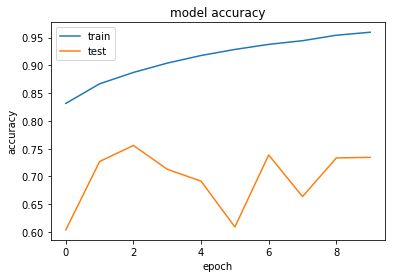

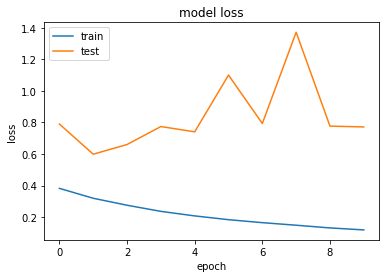

In [21]:
show_history_graph(hist)

## Test the initial model

In [22]:
# Load optimal weights from the training
model.load_weights('saved_models/weights.best.benchmark.hdf5')

# get index of prediction for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report on metrics

TP = 0  # true positives
TN = 0  # true negatives
FP = 0  # false positives
FN = 0  # false negatives

k = 0
for i in predictions:
    if i == 1 and np.argmax(test_targets, axis=1)[k] == 1:
        TP = TP + 1
    if i == 0 and np.argmax(test_targets, axis=1)[k] == 0:
        TN = TN + 1
    if i == 1 and np.argmax(test_targets, axis=1)[k] == 0:
        FP = FP + 1
    if i == 0 and np.argmax(test_targets, axis=1)[k] == 1:
        FN = FN + 1
        
    k = k + 1
    
### Accuracy
accuracy = 100 * (TP + TN) / len(predictions)

### Precision
precision = 100 * TP / (TP + FP)

### Recall
recall = 100 * TP / (TP + FN)

### F3-score
# Divide by 100 to scale the score back to [0, 1]
b = 3
fbscore = (1 / 100) * (1 + b*b) * precision * recall / (b * b * precision + recall)

### Print results
print("Test accuracy: %.4f%%" % accuracy)
print("Test Precision: %.4f%%" % precision)
print("Recall: %.4f%%" % recall)
print("F3-score: ",  fbscore)

Test accuracy: 74.6714%
Test Precision: 77.8626%
Recall: 70.9977%
F3-score:  0.7162921348314607


### Discussion

As we can see, **the initial model performs better than random (benchmark)**. It doesn't perform too well (only achieves 70% recall), and this is due to poor choices of network structure and architecture. However, this serves as a great motivation for us to start refining our architecture and parameters. We now start the refinement process and we eventually derive the final model architecture for both CNN and CNN-SVMC models. See the other code files for their implementation.